## Code Example for SVI Coverage Estimation based on Simplified Isovist Methods

In [2]:
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import pandas as pd
from tqdm import tqdm
from shapely.geometry import LineString, MultiLineString, Point

### Define Functions

In [3]:
def sample_points_from_geometry(geometry, interval):
    """Samples points from a given LineString or MultiLineString at specified intervals."""
    points = []
    if isinstance(geometry, LineString):
        points.extend(sample_points_along_line(geometry, interval))
    elif isinstance(geometry, MultiLineString):
        for line in geometry:
            points.extend(sample_points_along_line(line, interval))
    return points

def sample_points_along_line(line, interval):
    """Generate points along a LineString at a fixed interval."""
    num_samples = max(int(line.length / interval), 1)  # Ensure at least one sample
    # Adjust the interpolation to ensure it's always within the line's bounds
    return [line.interpolate(float(i) / (num_samples - 1) * line.length) if num_samples > 1 else line.interpolate(0) for i in range(num_samples)]


def generate_isovist(viewpoint_id, viewpoint_geom, grid_points, buildings, buildings_sindex, grid_points_sindex, buffer_radius):
    # Buffer the viewpoint geometry
    buffered_area = viewpoint_geom.buffer(buffer_radius)
    
    # Spatial index queries
    possible_building_matches_index = list(buildings_sindex.intersection(buffered_area.bounds))
    nearby_buildings = buildings.iloc[possible_building_matches_index]
    nearby_buildings = nearby_buildings[nearby_buildings.intersects(buffered_area)]
    possible_grid_matches_index = list(grid_points_sindex.intersection(buffered_area.bounds))
    nearby_grid_points = grid_points.iloc[possible_grid_matches_index]
    nearby_grid_points = nearby_grid_points[nearby_grid_points.intersects(buffered_area)]
    
    visible_points_with_id = []
    for grid_point in nearby_grid_points.geometry:
        line = LineString([viewpoint_geom, grid_point])
        if not nearby_buildings.intersects(line).any():
            # Append the visible point along with viewpoint ID
            visible_point = line.interpolate(1, normalized=True)
            visible_points_with_id.append((visible_point, viewpoint_id))
    
    return visible_points_with_id

### Import Level 7 H3 Grids for Greater London

In [5]:
hexagon_gdf = gpd.read_file("data/London_h3_84_level_7.gpkg").to_crs(27700)

<Axes: >

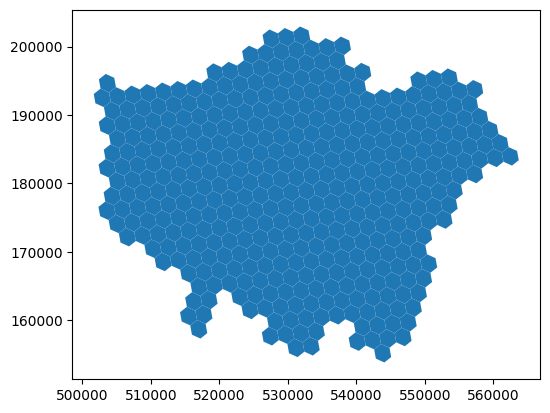

In [6]:
hexagon_gdf.plot()

### Import buildings, buildings in the buffer area, SVI locations in the buffer area

In [19]:
# define the H3 id
layer_H3_id = 'h3_87194ad32ffffff'

# input the buildings in buffer
building_200m_buffer_path = 'data/London_building_200_buffered_level_7_h3_87194ad32ffffff.gpkg'
building_200m_buffer_specific = gpd.read_file(building_200m_buffer_path)

# input the H3 grid
hexagon_specific= hexagon_gdf[hexagon_gdf['h3_id'] == layer_H3_id.split('_')[1]]

# input the buildings 
#buildings_specific = gpd.sjoin(building_200m_buffer_specific,hexagon_specific[['geometry']], how = 'inner')


# input the buildings in buffer
building_path = 'data/London_building_level_7_h3_87194ad32ffffff.gpkg'
buildings_specific = gpd.read_file(building_path)


# input the SVI locations
recent_svi_point_specific_path = 'data/London_recent_SVI_200_buffered_level_7_h3_87194ad32ffffff.gpkg'
recent_svi_point_specific = gpd.read_file(recent_svi_point_specific_path)


### Extract Building sampling Points

In [9]:

from shapely.ops import unary_union
import geopandas as gpd
import time


start_time = time.time()
building_gdf = buildings_specific

# Extract boundaries at once
merged_buildings_geometry = unary_union(building_gdf.geometry)
building_boundaries = merged_buildings_geometry.boundary

# Initialize a list to hold all sampled points
all_points = []

# If 'building_boundaries' is a MultiLineString, you need to iterate through its parts
if hasattr(building_boundaries, 'geoms'):
    for boundary in building_boundaries.geoms:
        boundary_points = sample_points_from_geometry(boundary, 2)  # 2m interval
        all_points.extend(boundary_points)
else:  # If it's just a single LineString
    all_points.extend(sample_points_from_geometry(building_boundaries, 2))

# Convert all sampled points into a GeoDataFrame
sampling_points_gdf = gpd.GeoDataFrame({'geometry': all_points}, crs=building_gdf.crs)
sampling_points_deduplicated = sampling_points_gdf.drop_duplicates(subset='geometry', keep='first')

# Apply unary_union to dissolve the geometries in 'building_200m_buffer_specific'
merged_building_200m_buffer_specific_geometry = unary_union(building_200m_buffer_specific.geometry)
# Create a new GeoDataFrame from the merged geometry
building_200m_buffer_specific_dissolved = gpd.GeoDataFrame(geometry=[merged_building_200m_buffer_specific_geometry], crs=building_200m_buffer_specific.crs)
building_200m_buffer_specific_dissolved.geometry = building_200m_buffer_specific_dissolved.geometry.buffer(-0.1)

# Perform spatial join to find points within the dissolved building geometries
points_within_buildings = gpd.sjoin(sampling_points_deduplicated, building_200m_buffer_specific_dissolved, how='inner', predicate='within')

# Filter out points that are within buildings
sampling_points_deduplicated_outside = sampling_points_deduplicated[~sampling_points_deduplicated.index.isin(points_within_buildings.index)].drop_duplicates()
end_time = time.time()
print(end_time - start_time)

6.936182737350464


In [11]:
sampling_points_deduplicated_outside

,geometry
0,POINT (530144.733 180647.438)
1,POINT (530146.741 180647.818)
2,POINT (530148.749 180648.198)
3,POINT (530150.757 180648.579)
4,POINT (530152.765 180648.956)
...,...
113537,POINT (532174.604 181643.344)
113538,POINT (532176.629 181643.518)
113539,POINT (532178.655 181643.693)
113540,POINT (532180.563 181642.998)


### Visualize building sampling points and SVI locations

(529605.2158309522, 532881.4137848616, 179081.26061251576, 182546.0262422374)

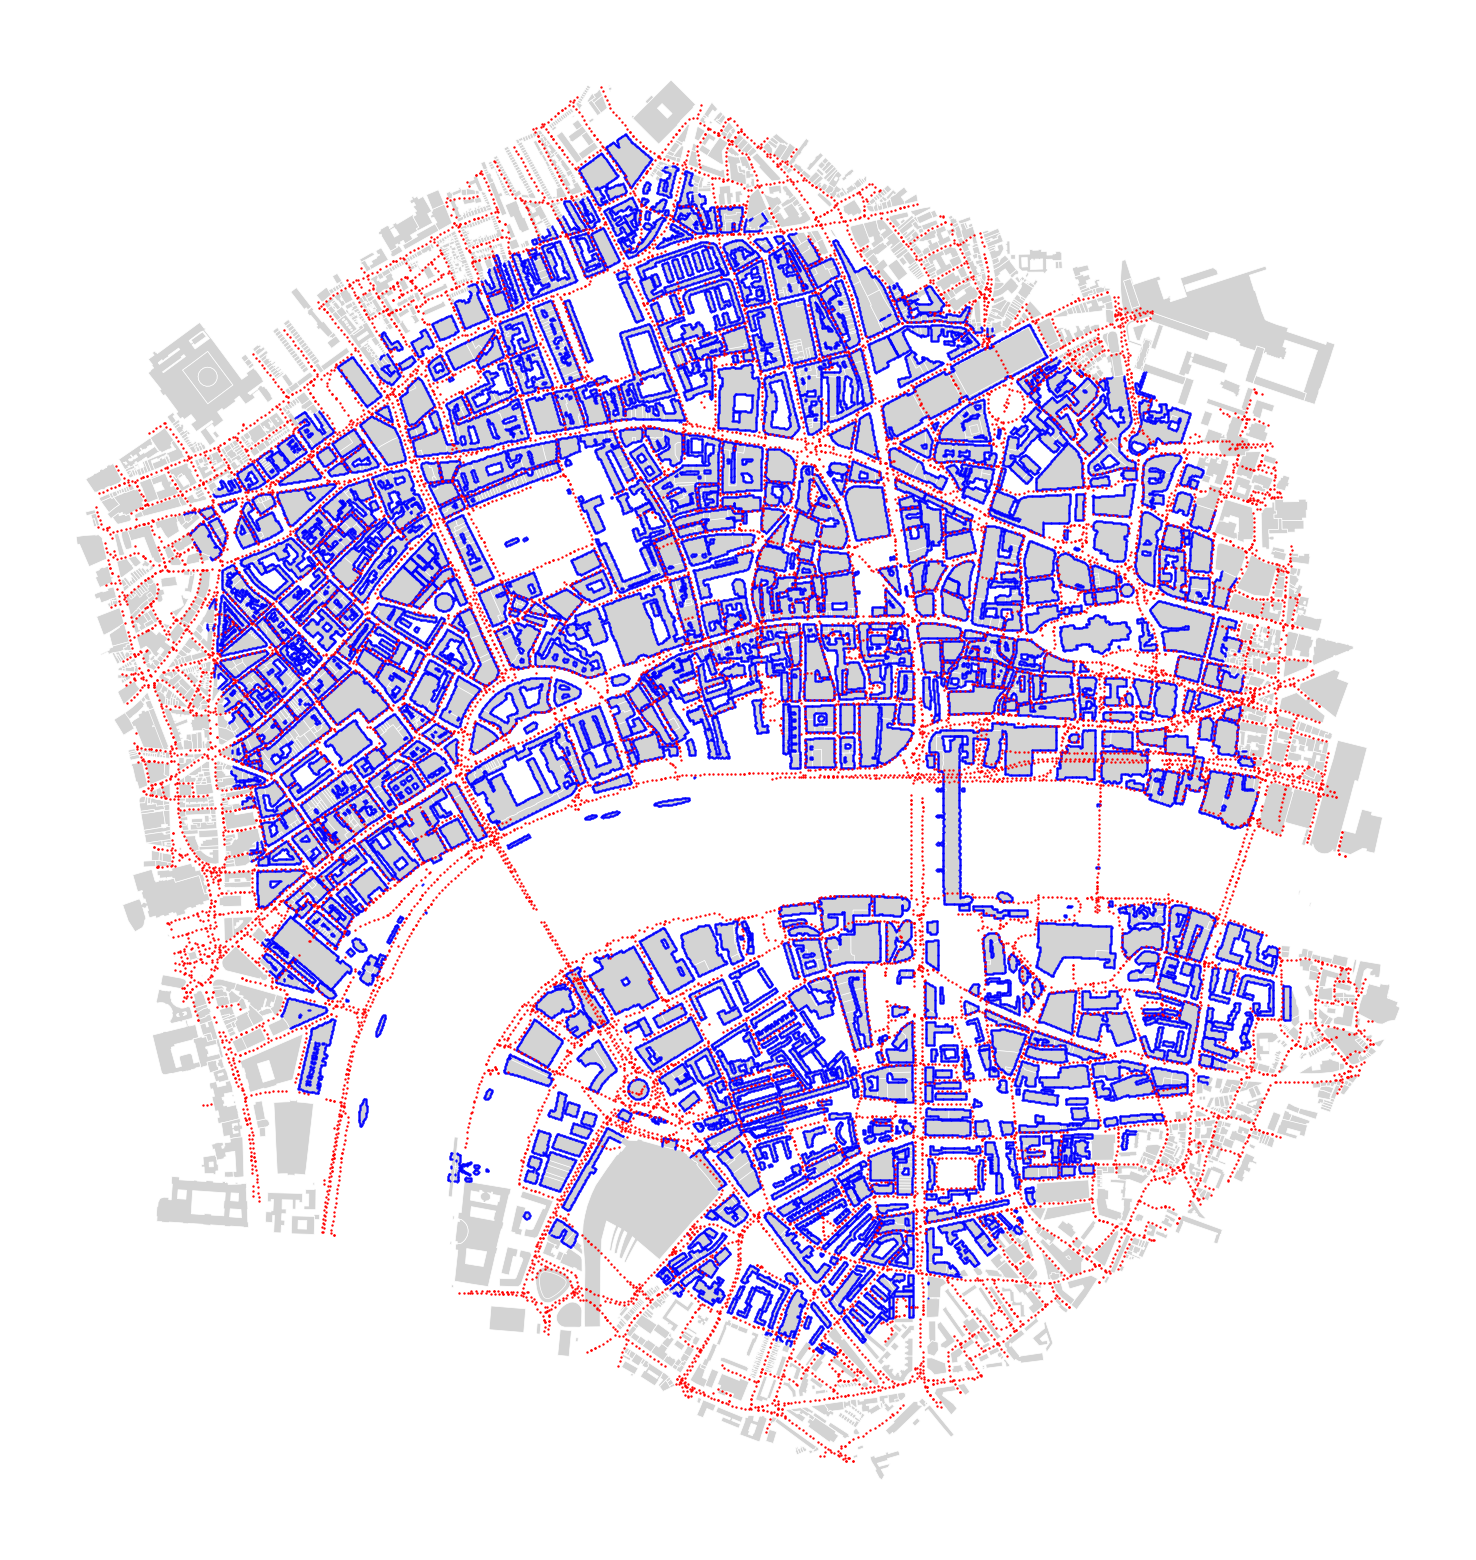

In [12]:
import matplotlib.pyplot as plt
from shapely.geometry import box



_, basemap = plt.subplots(figsize=(20, 20))
building_gdf.plot(ax=basemap, color='grey', edgecolor='white', linewidth=0.5)
building_200m_buffer_specific.plot(ax=basemap, color='lightgrey', edgecolor='white', linewidth=0.5)
sampling_points_deduplicated_outside .plot(ax=basemap, color='blue', markersize=0.3)
recent_svi_point_specific.plot(ax=basemap, color='red', markersize=0.5, )  # Adjust markersize as needed


plt.axis('off')


### Carry out Isovist Analysis

In [16]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from tqdm import tqdm


# Load your data here
viewpoints = recent_svi_point_specific
buildings = building_200m_buffer_specific.geometry.boundary
grid_points = sampling_points_deduplicated.geometry
buildings_sindex = buildings.sindex
grid_points_sindex = grid_points.sindex
buffer_radius = 50

visible_points_with_id_list = []

for index, row in tqdm(viewpoints.iterrows(), total=len(viewpoints), desc="Processing Viewpoints"):
#for index, row in tqdm(viewpoints.iterrows(), total=len(viewpoints), desc="Processing Viewpoints"):
    viewpoint_id = row['image_id']  # Assuming the ID column is named 'id'
    viewpoint_geom = row.geometry
    
    visible_points_with_id = generate_isovist(viewpoint_id, viewpoint_geom, grid_points, buildings, buildings_sindex, grid_points_sindex, buffer_radius)
    visible_points_with_id_list.extend(visible_points_with_id)
# Create a GeoDataFrame from the list of tuples (visible point, ID)
all_visible_points = gpd.GeoDataFrame(visible_points_with_id_list, columns=['geometry', 'viewpoint_id'], crs=grid_points.crs)


Processing Viewpoints:   0%|          | 0/19213 [00:00<?, ?it/s]

Processing Viewpoints: 100%|██████████| 19213/19213 [09:24<00:00, 34.06it/s] 


### Visualize Visible Building Sampling Points and SVI locations 

(529605.2158309522, 532881.4137848616, 179081.26061251576, 182546.0262422374)

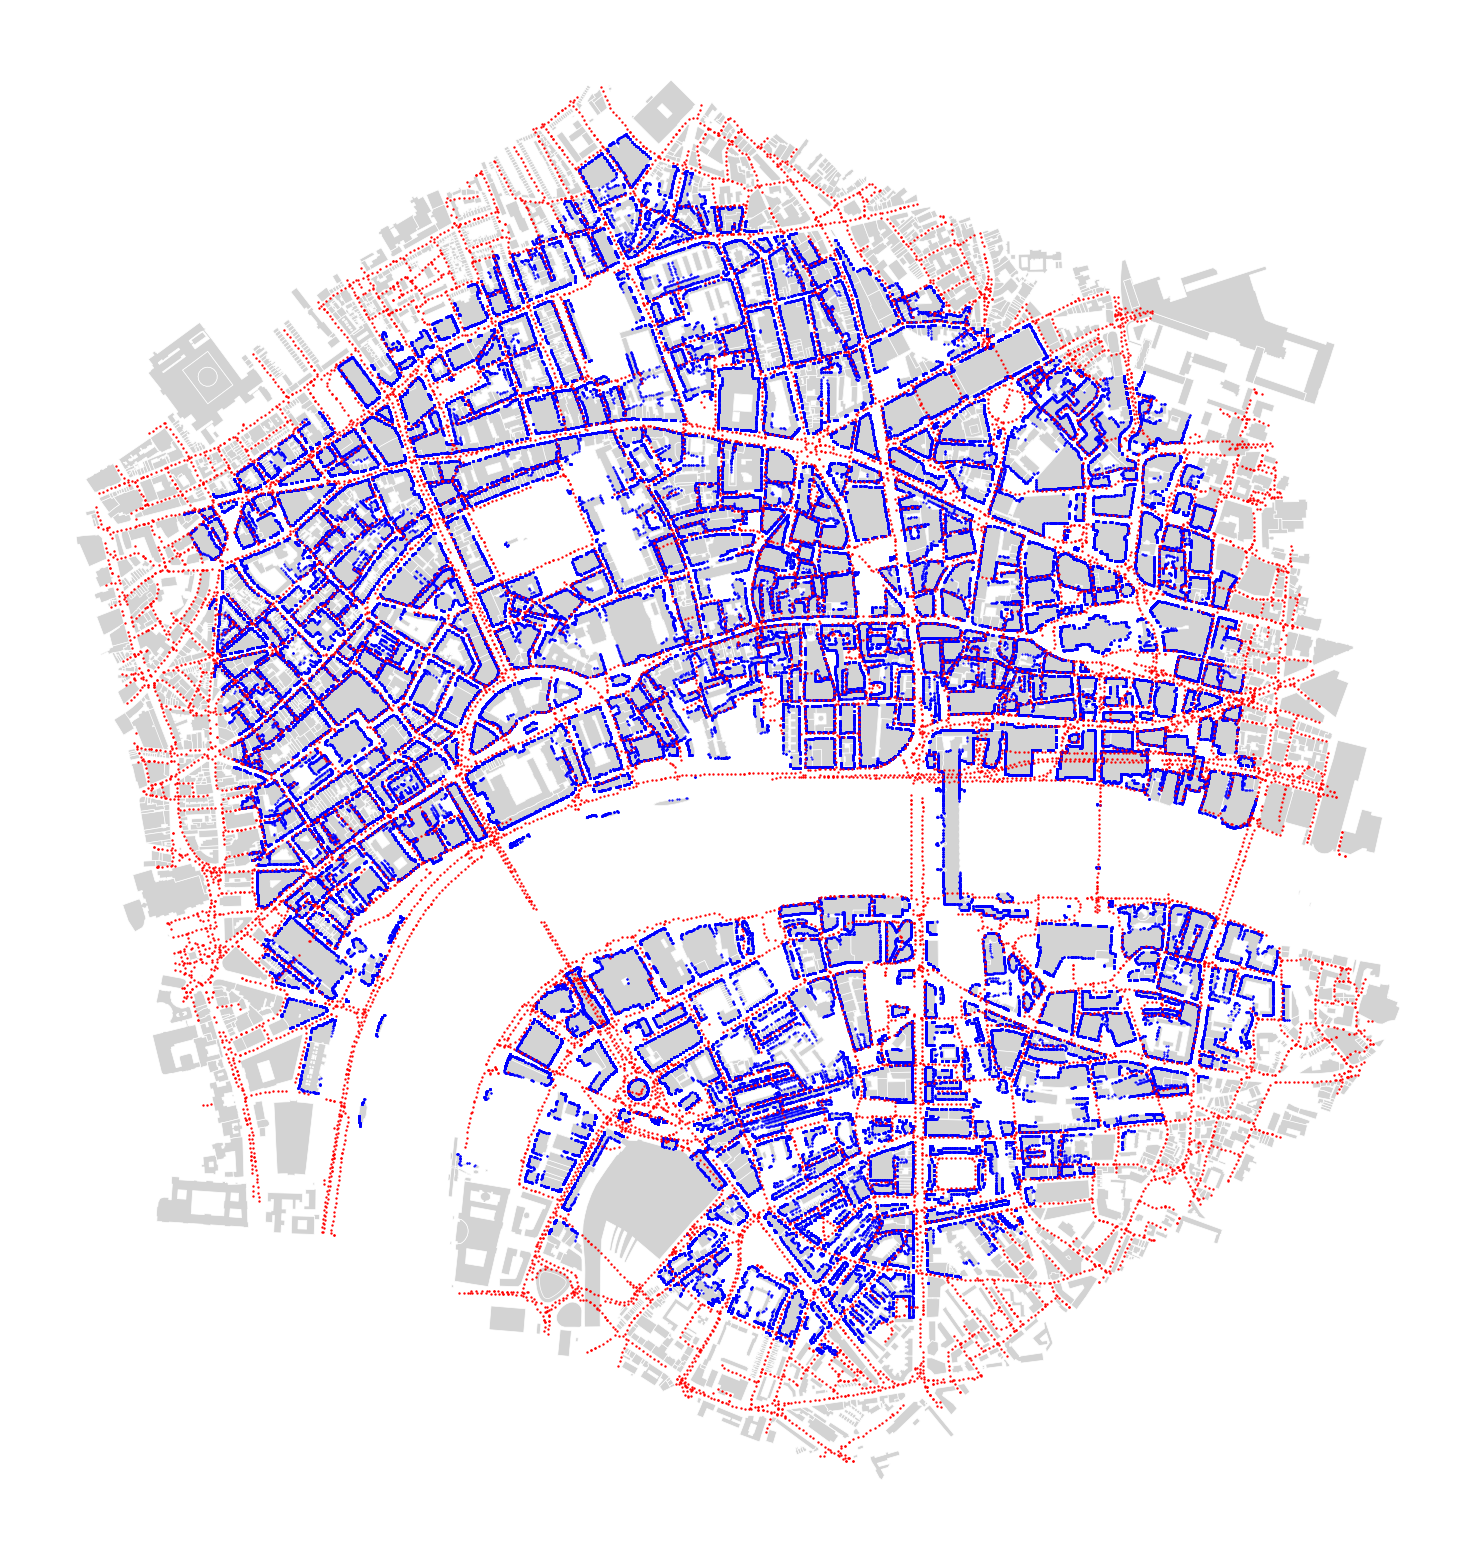

In [20]:
import matplotlib.pyplot as plt
from shapely.geometry import box

_, basemap = plt.subplots(figsize=(20, 20))
building_gdf.plot(ax=basemap, color='grey', edgecolor='white', linewidth=0.5)
building_200m_buffer_specific.plot(ax=basemap, color='lightgrey', edgecolor='white', linewidth=0.5)
all_visible_points .plot(ax=basemap, color='blue', markersize=0.3)
recent_svi_point_specific.plot(ax=basemap, color='red', markersize=0.5, )  # Adjust markersize as needed


plt.axis('off')


### Automate the isovist Processing

In [1]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import os
import tempfile
import shutil


# Define the function to sample points from geometry
def sample_points_from_geometry(geometry, interval):
    """Samples points from a given LineString or MultiLineString at specified intervals."""
    points = []
    if isinstance(geometry, LineString):
        points.extend(sample_points_along_line(geometry, interval))
    elif isinstance(geometry, MultiLineString):
        for line in geometry:
            points.extend(sample_points_along_line(line, interval))
    return points

# Define the function to sample points along a line
def sample_points_along_line(line, interval):
    """Generate points along a LineString at a fixed interval."""
    num_samples = max(int(line.length / interval), 1)  # Ensure at least one sample
    # Adjust the interpolation to ensure it's always within the line's bounds
    return [line.interpolate(float(i) / (num_samples - 1) * line.length) if num_samples > 1 else line.interpolate(0) for i in range(num_samples)]


# Define the function to generate isovists
def generate_isovist(viewpoint_id, viewpoint_geom, grid_points, buildings, buildings_sindex, grid_points_sindex, buffer_radius = 50):
    """Generate isovist for a given viewpoint."""
    # Buffer the viewpoint geometry
    buffered_area = viewpoint_geom.buffer(buffer_radius)
    
    # Spatial index queries
    possible_building_matches_index = list(buildings_sindex.intersection(buffered_area.bounds))
    nearby_buildings = buildings.iloc[possible_building_matches_index]
    nearby_buildings = nearby_buildings[nearby_buildings.intersects(buffered_area)]
    possible_grid_matches_index = list(grid_points_sindex.intersection(buffered_area.bounds))
    nearby_grid_points = grid_points.iloc[possible_grid_matches_index]
    nearby_grid_points = nearby_grid_points[nearby_grid_points.intersects(buffered_area)]
    
    visible_points_with_id = []
    for grid_point in nearby_grid_points.geometry:
        line = LineString([viewpoint_geom, grid_point])
        if not nearby_buildings.intersects(line).any():
            # Append the visible point along with viewpoint ID
            visible_point = line.interpolate(1, normalized=True)
            visible_points_with_id.append((visible_point, viewpoint_id))
    
    return visible_points_with_id

# Define the function to process data for a single H3 ID
def process_h3_id(layer_H3_id, building_path, building_200m_buffer_path, recent_svi_point_specific_path, base_csv_path):
    """Process data for a single H3 ID and save the output to CSV."""
    # Filter data for the specific H3 ID
    building_200m_buffer_specific = gpd.read_file(building_200m_buffer_path, layer=layer_H3_id)
    buildings_specific = gpd.read_file(building_path, layer=layer_H3_id)
    recent_svi_point_specific = gpd.read_file(recent_svi_point_specific_path, layer=layer_H3_id)
    
    # Generate sampling points
    #merged_buildings = buildings_specific.dissolve()
    #building_boundaries = merged_buildings.geometry.boundary

    merged_buildings_geometry = unary_union(buildings_specific.geometry)
    building_boundaries = merged_buildings_geometry.boundary
    
    all_points = []
    if hasattr(building_boundaries, 'geoms'):
        for boundary in building_boundaries.geoms:
            boundary_points = sample_points_from_geometry(boundary, 2)  # 2m interval
            all_points.extend(boundary_points)
    else:  # If it's just a single LineString
        all_points.extend(sample_points_from_geometry(building_boundaries, 2))

    # Convert all sampled points into a GeoDataFrame
    sampling_points_gdf = gpd.GeoDataFrame({'geometry': all_points}, crs=buildings_specific.crs)
    sampling_points_deduplicated = sampling_points_gdf.drop_duplicates(subset='geometry', keep='first')

    # Apply unary_union to dissolve the geometries in 'building_200m_buffer_specific'
    merged_building_200m_buffer_specific_geometry = unary_union(building_200m_buffer_specific.geometry)
    # Create a new GeoDataFrame from the merged geometry
    building_200m_buffer_specific_dissolved = gpd.GeoDataFrame(geometry=[merged_building_200m_buffer_specific_geometry], crs=building_200m_buffer_specific.crs)
    building_200m_buffer_specific_dissolved.geometry = building_200m_buffer_specific_dissolved.geometry.buffer(-0.1)

    # Perform spatial join to find points within the dissolved building geometries
    points_within_buildings = gpd.sjoin(sampling_points_deduplicated, building_200m_buffer_specific_dissolved, how='inner', predicate='within')

    # Filter out points that are within buildings
    sampling_points_deduplicated = sampling_points_deduplicated[~sampling_points_deduplicated.index.isin(points_within_buildings.index)].drop_duplicates()
    
    # Generate isovists
    visible_points_with_id_list = []
    for index, row in tqdm(recent_svi_point_specific.iterrows(), total=len(recent_svi_point_specific), desc=f"Processing {layer_H3_id}"):
        visible_points_with_id = generate_isovist(row['image_id'], row.geometry, sampling_points_deduplicated.geometry, buildings_specific.geometry.boundary, buildings_specific.sindex, sampling_points_deduplicated.sindex, 50)
        visible_points_with_id_list.extend(visible_points_with_id)
    
    # Create a GeoDataFrame from the list of tuples (visible point, ID)
    all_visible_points = gpd.GeoDataFrame(visible_points_with_id_list, columns=['geometry', 'viewpoint_id'], crs=sampling_points_gdf.crs)
    # join points by the building buffer (which is used to deduplicates the sampling points)
    # only getting same result indicates we do things well 
    building_buffer = buildings_specific.copy()
    building_buffer.geometry = building_buffer.geometry.buffer(0.1)
    all_visible_points_joined_building_id = gpd.sjoin(all_visible_points,building_buffer,how = 'left')
    all_visible_points_joined_building_id_drop_duplicates = all_visible_points_joined_building_id.groupby(["geometry",'viewpoint_id','osm_id']).first().reset_index()
    
    # Save to CSV
    csv_path = f"{base_csv_path}visible_points_{layer_H3_id}.csv"
    save_to_csv(all_visible_points_joined_building_id_drop_duplicates, csv_path)

# Define the function to save data to CSV
def save_to_csv(gdf, file_path):
    """Save GeoDataFrame data to a CSV file."""
    # Convert geometries to WKT format
    df = gdf.copy()
    df['geometry'] = df['geometry'].apply(lambda x: x.wkt)
    
    # Save to CSV
    df.to_csv(file_path, index=False)



In [15]:
# Specify file paths and H3 IDs
#new_hexagon_gdf = gpd.read_file("Data/Geopackage_shp/London_h3_84_level_7_additional_52_90_percent.gpkg").to_crs(27700)
#new_hexagon_gdf.h3_id.values

array(['87195d362ffffff', '87194ad15ffffff', '87194ad06ffffff',
       '87194ad23ffffff', '87194ada5ffffff', '87194ad16ffffff',
       '87194ad14ffffff', '87194ad33ffffff', '87194ad31ffffff',
       '87194ad22ffffff', '87194ad20ffffff', '87194ada4ffffff',
       '87195da4bffffff', '87194ad25ffffff', '87194e6d6ffffff',
       '87194e6f3ffffff', '87194e6f1ffffff', '87195da49ffffff',
       '87194ad32ffffff', '87194ad30ffffff', '87194ad35ffffff',
       '87194ad26ffffff', '87194ad24ffffff', '87195da59ffffff',
       '87195da4affffff', '87195da48ffffff', '87194e689ffffff',
       '87194e6f2ffffff', '87194e6f0ffffff', '87194e6f5ffffff',
       '87195da4dffffff', '87194ad36ffffff', '87194ad34ffffff',
       '87194e69bffffff', '87194e699ffffff', '87194e68affffff',
       '87195da4effffff', '87195da4cffffff', '87195da6bffffff',
       '87195da69ffffff', '87194e69affffff', '87194e698ffffff',
       '87194e69dffffff', '87195da6affffff', '87195da68ffffff',
       '87195da6dffffff', '87194e69effff

In [ ]:
# Specify file paths and H3 IDs
#hexagon_gdf = gpd.read_file("Data/Geopackage_shp/London_h3_84_level_7.gpkg").to_crs(27700)
#building_path = 'Data/Geopackage_shp/London_building_h3_level_7_geopackage.gpkg'
#building_200m_buffer_path = 'Data/Geopackage_shp/London_building_200_buffered_h3_level_7_geopackage.gpkg'
#recent_svi_point_specific_path = 'Data/Geopackage_shp/London_recent_SVI_200_buffered_h3_level_7_geopackage.gpkg'
#base_csv_path = 'Data/Geopackage_shp/SVI_collection/prelimiary_result_collection/'

#new_h3_ids = ['h3_{}'.format(e) for e in new_hexagon_gdf.h3_id.values]

#ids_to_process = [item for item in new_h3_ids if item not in h3_ids]
#len(ids_to_process)

In [17]:
#for h3_id in ids_to_process:
#    process_h3_id(h3_id, building_path, building_200m_buffer_path, recent_svi_point_specific_path, base_csv_path)

Processing h3_87194e695ffffff: 100%|███████████████████████████████████████████████| 9127/9127 [06:10<00:00, 24.64it/s]
